In [1]:
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import cv2
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



In [2]:
#csv_file = "../data/train_labels.csv"
#csv_file_2 = "../data/train_labels_2.csv"
csv_file = "../train/data/labels/labels.csv"

df = pd.read_csv(csv_file)
#df_2 = pd.read_csv(csv_file_2)
#df = pd.concat([df_1, df_2], ignore_index=True, )
df.rename(columns={'Bags used ': 'bags_used', 'Pothole number': 'pothole_number'}, inplace=True)


In [3]:
annotations_folder = "../train/data/annotations/"
#annotations_folder_2 = "../data/train_annotations_2/"
predict_anno = "../predictions/annotations/"

In [4]:

# List to store the extracted data
data = []

# Loop through each annotation file
for file_name in os.listdir(annotations_folder):
    if file_name.endswith('.txt'):
        image_name = file_name.replace('.txt', '')  # Assuming image has the same name as the annotation file
        
        # Open and read the annotation file
        with open(os.path.join(annotations_folder, file_name), 'r') as file:
            for line in file:
                # Split the line into its components
                class_id, x_center, y_center, width, height = line.strip().split()
                
                # Append the data to the list
                data.append({
                    'image_name': image_name,
                    'class_id': int(class_id),
                    'x_center': float(x_center),
                    'y_center': float(y_center),
                    'width': float(width),
                    'height': float(height)
                })

# Convert the list to a DataFrame
anno = pd.DataFrame(data)


In [5]:
predict_anno

'../predictions/annotations/'

In [6]:

# List to store the extracted data
predict_data = []

# Loop through each annotation file
for file_name in os.listdir(predict_anno):
    if file_name.endswith('.txt'):
        image_name = file_name.replace('.txt', '')  # Assuming image has the same name as the annotation file
        
        # Open and read the annotation file
        with open(os.path.join(predict_anno, file_name), 'r') as file:
            for line in file:
                # Split the line into its components
                class_id, x_center, y_center, width, height = line.strip().split()
                
                # Append the data to the list
                predict_data.append({
                    'image_name': image_name,
                    'class_id': int(class_id),
                    'x_center': float(x_center),
                    'y_center': float(y_center),
                    'width': float(width),
                    'height': float(height)
                })

# Convert the list to a DataFrame
predict_annotations = pd.DataFrame(predict_data)


In [7]:
# data = []

# # Loop through each annotation file
# for file_name in os.listdir(annotations_folder_2):
#     if file_name.endswith('.txt'):
#         image_name = file_name.replace('.txt', '')  # Assuming image has the same name as the annotation file
        
#         # Open and read the annotation file
#         with open(os.path.join(annotations_folder_2, file_name), 'r') as file:
#             for line in file:
#                 # Split the line into its components
#                 class_id, x_center, y_center, width, height = line.strip().split()
                
#                 # Append the data to the list
#                 data.append({
#                     'image_name': image_name,
#                     'class_id': int(class_id),
#                     'x_center': float(x_center),
#                     'y_center': float(y_center),
#                     'width': float(width),
#                     'height': float(height)
#                 })

# # Convert the list to a DataFrame
#anno_2 = pd.DataFrame(data)

 # Display the DataFrame
#print(anno_2.head())

In [8]:
annotations = anno
#annotations = pd.concat([anno, anno_2], ignore_index=True, )
annotations['pothole_number'] = annotations['image_name'].str.replace('p', '').astype(int)

In [9]:
df = df.drop_duplicates()
df_annotations = annotations.merge(df,on='pothole_number', how="inner", suffixes=('', '_df'))
df_annotations['img_file'] = 'p' + df_annotations['pothole_number'].astype(str) + '.jpg'

In [10]:
predict_annotations['pothole_number'] = predict_annotations['image_name'].str.replace('p', '').astype(int)
predict_annotations = predict_annotations.drop_duplicates()
predict_annotations['img_file'] = 'p' + predict_annotations['pothole_number'].astype(str) + '.jpg'

In [11]:
valid = [] 
for file in df_annotations['img_file']:
    name = '../train/data/images/' + file 
    if os.path.exists(name):
        valid.append(file)

In [12]:
len(valid)

1519

In [13]:
valid_df = df_annotations[df_annotations['img_file'].isin(valid)]
valid_df

,image_name,class_id,x_center,y_center,width,height,pothole_number,bags_used,img_file
0,p1336,1,0.634134,0.553173,0.562607,0.094340,1336,0.25,p1336.jpg
1,p930,0,0.449839,0.499142,0.799943,0.998284,930,3.00,p930.jpg
2,p930,1,0.550746,0.162950,0.071658,0.325900,930,3.00,p930.jpg
3,p924,1,0.777287,0.467410,0.445397,0.049743,924,0.50,p924.jpg
4,p924,0,0.519282,0.546312,0.917953,0.704974,924,0.50,p924.jpg
...,...,...,...,...,...,...,...,...,...
1514,p929,0,0.528169,0.550600,0.782471,0.874786,929,1.00,p929.jpg
1515,p929,1,0.284582,0.493139,0.567462,0.073756,929,1.00,p929.jpg
1516,p1449,1,0.551801,0.553173,0.072041,0.598628,1449,0.50,p1449.jpg
1517,p1449,0,0.569811,0.598628,0.468268,0.490566,1449,0.50,p1449.jpg


In [14]:
valid_df

,image_name,class_id,x_center,y_center,width,height,pothole_number,bags_used,img_file
0,p1336,1,0.634134,0.553173,0.562607,0.094340,1336,0.25,p1336.jpg
1,p930,0,0.449839,0.499142,0.799943,0.998284,930,3.00,p930.jpg
2,p930,1,0.550746,0.162950,0.071658,0.325900,930,3.00,p930.jpg
3,p924,1,0.777287,0.467410,0.445397,0.049743,924,0.50,p924.jpg
4,p924,0,0.519282,0.546312,0.917953,0.704974,924,0.50,p924.jpg
...,...,...,...,...,...,...,...,...,...
1514,p929,0,0.528169,0.550600,0.782471,0.874786,929,1.00,p929.jpg
1515,p929,1,0.284582,0.493139,0.567462,0.073756,929,1.00,p929.jpg
1516,p1449,1,0.551801,0.553173,0.072041,0.598628,1449,0.50,p1449.jpg
1517,p1449,0,0.569811,0.598628,0.468268,0.490566,1449,0.50,p1449.jpg


In [15]:

# input_image_folder = '../train/data/images/'  # Folder containing original images
# output_image_folder = '../data/resized_images/'     # Folder to save resized images
# os.makedirs(output_image_folder, exist_ok=True)

# # Assuming df is your DataFrame
# # Add columns for original image dimensions
# valid_df['image_height'] = None
# valid_df['image_width'] = None
# valid_df['x_new'] = None
# valid_df['y_new'] = None
# valid_df['width_new'] = None
# valid_df['height_new'] = None

# # Function to update bounding boxes for the new image size
# target_width, target_height = 512, 512

# # Function to update bounding boxes for the new image size
# def update_bounding_boxes(row, target_size=(512, 512)):
#     original_width = row['image_width']
#     original_height = row['image_height']
    
#     # New target dimensions
#     target_width, target_height = target_size
    
#     # Update bounding box coordinates
#     #print(target_width)
#     #print(original_width)

#     row.loc['x_new'] = row['x_center'] * target_width / original_width
#     row.loc['y_new'] = row['y_center'] * target_height / original_height
#     row.loc['width_new'] = row['width'] * target_width / original_width
#     row.loc['height_new'] = row['height'] * target_height / original_height
    
#     return row

# # Process each row in the DataFrame
# for index, row in valid_df.iterrows():
#     image_path = os.path.join(input_image_folder, row['img_file'])
    
    # Load the image to get its dimensions
#     image = cv2.imread(image_path)
#     #if image is not None:
#      #   continue  # Skip if the image cannot be loaded
    
#     original_height, original_width = image.shape[:2]
#     #print(original_height)
#     #print(original_width)
#     # Update DataFrame with original dimensions
#     valid_df.at[index, 'image_height'] = original_height
#     valid_df.at[index, 'image_width'] = original_width
#     #print(valid_df.at[index, 'image_height'])
    
#     # Update the bounding boxes based on the new size
#     valid_df.iloc[index] = update_bounding_boxes(valid_df.iloc[index], target_size=(512, 512))
    
#     # Resize the image
#     resized_image = cv2.resize(image, (512, 512))
    
#     # Save the resized image
#     output_image_path = os.path.join(output_image_folder, row['img_file'])
#     cv2.imwrite(output_image_path, resized_image)

# # Now df contains updated annotations and the original image dimensions
# # Save the updated DataFrame to a new CSV file
# #df.to_csv('updated_annotations.csv', index=False)


In [16]:
valid_df

,image_name,class_id,x_center,y_center,width,height,pothole_number,bags_used,img_file
0,p1336,1,0.634134,0.553173,0.562607,0.094340,1336,0.25,p1336.jpg
1,p930,0,0.449839,0.499142,0.799943,0.998284,930,3.00,p930.jpg
2,p930,1,0.550746,0.162950,0.071658,0.325900,930,3.00,p930.jpg
3,p924,1,0.777287,0.467410,0.445397,0.049743,924,0.50,p924.jpg
4,p924,0,0.519282,0.546312,0.917953,0.704974,924,0.50,p924.jpg
...,...,...,...,...,...,...,...,...,...
1514,p929,0,0.528169,0.550600,0.782471,0.874786,929,1.00,p929.jpg
1515,p929,1,0.284582,0.493139,0.567462,0.073756,929,1.00,p929.jpg
1516,p1449,1,0.551801,0.553173,0.072041,0.598628,1449,0.50,p1449.jpg
1517,p1449,0,0.569811,0.598628,0.468268,0.490566,1449,0.50,p1449.jpg


In [17]:
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    x_min = (x_center - width / 2) * img_width
    x_max = (x_center + width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    y_max = (y_center + height / 2) * img_height
    return x_min, y_min, x_max, y_max

# Calculate the diagonal length of the bounding box for `class_id` 1
def calculate_stick_size(row, img_width, img_height):
    if (row['class_id'] != 1):
        return 0
    x_min, y_min, x_max, y_max = yolo_to_bbox(
        row['x_new'], row['y_new'], row['width_new'], row['height_new'], img_width, img_height
    )
    return np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)

def calculate_stick_size_old(row, img_width, img_height):
    if (row['class_id'] != 1):
        return 0
    x_min, y_min, x_max, y_max = yolo_to_bbox(
        row['x_center'], row['y_center'], row['width'], row['height'], img_width, img_height
    )
    return np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)

def calculate_pothole_size_old(row, img_width, img_height):
    if (row['class_id'] != 0):
        return 0
    x_min, y_min, x_max, y_max = yolo_to_bbox(
        row['x_center'], row['y_center'], row['width'], row['height'], img_width, img_height
    )
    return np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)



# Example function to load an image and get its dimensions
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

# Add a column with stick sizes
# valid_df['stick_size'] = valid_df.apply(
#     lambda row: calculate_stick_size(row, *get_image_size(f'../data/resized_images/{row["img_file"]}')),
#     axis=1
# )
valid_df['stick_size'] = valid_df.apply(
    lambda row: calculate_stick_size_old(row, *get_image_size(f'../train/data/images/{row["img_file"]}')),
    axis=1
)
valid_df['pothole_size'] = valid_df.apply(
    lambda row: calculate_pothole_size_old(row, *get_image_size(f'../train/data/images/{row["img_file"]}')),
    axis=1
)

In [18]:
df_annotations = valid_df.copy()

In [19]:
df_annotations

,image_name,class_id,x_center,y_center,width,height,pothole_number,bags_used,img_file,stick_size,pothole_size
0,p1336,1,0.634134,0.553173,0.562607,0.094340,1336,0.25,p1336.jpg,215.634563,0.000000
1,p930,0,0.449839,0.499142,0.799943,0.998284,930,3.00,p930.jpg,0.000000,586.357766
2,p930,1,0.550746,0.162950,0.071658,0.325900,930,3.00,p930.jpg,144.049049,0.000000
3,p924,1,0.777287,0.467410,0.445397,0.049743,924,0.50,p924.jpg,214.624561,0.000000
4,p924,0,0.519282,0.546312,0.917953,0.704974,924,0.50,p924.jpg,0.000000,515.663500
...,...,...,...,...,...,...,...,...,...,...,...
1514,p929,0,0.528169,0.550600,0.782471,0.874786,929,1.00,p929.jpg,0.000000,566.881846
1515,p929,1,0.284582,0.493139,0.567462,0.073756,929,1.00,p929.jpg,309.195260,0.000000
1516,p1449,1,0.551801,0.553173,0.072041,0.598628,1449,0.50,p1449.jpg,227.914061,0.000000
1517,p1449,0,0.569811,0.598628,0.468268,0.490566,1449,0.50,p1449.jpg,0.000000,256.352544


In [20]:
predict_annotations['stick_size'] = predict_annotations.apply(
    lambda row: calculate_stick_size_old(row, *get_image_size(f'../predictions/images/{row["img_file"]}')),
    axis=1
)
predict_annotations['pothole_size'] = predict_annotations.apply(
    lambda row: calculate_pothole_size_old(row, *get_image_size(f'../predictions/images/{row["img_file"]}')),
    axis=1
)

In [21]:
df_annotations['stick_size'] = df_annotations.groupby('pothole_number')['stick_size'].transform(
    lambda x: x.replace(0, x.max())
)
df_annotations['pothole_size'] = df_annotations.groupby('pothole_number')['pothole_size'].transform(
    lambda x: x.replace(0, x.max())
)
# If stick_size is still zero, populate it with the mean of non-zero stick_size values
mean_stick_size = df_annotations['stick_size'].replace(0, np.nan).mean()
df_annotations['stick_size'] = df_annotations['stick_size'].replace(0, mean_stick_size)

mean_pot_size = df_annotations['pothole_size'].replace(0, np.nan).mean()
df_annotations['pothole_size'] = df_annotations['pothole_size'].replace(0, mean_stick_size)

In [22]:

predict_annotations['stick_size'] = predict_annotations.groupby('pothole_number')['stick_size'].transform(
    lambda x: x.replace(0, x.max())
)

predict_annotations['pothole_size'] = predict_annotations.groupby('pothole_number')['pothole_size'].transform(
    lambda x: x.replace(0, x.max())
)
predict_annotations['pothole_size'] = predict_annotations['pothole_size'].replace(0, mean_pot_size)

In [23]:
#df_annotations['has_pothole'] = df_annotations.groupby('pothole_number')['class_id'].transform(lambda x: (x == 0).any())


In [24]:
df_annotations = df_annotations.reset_index(drop=True)
df_annotations['stick_size'].idxmax()


1073

In [25]:
df_annotations['ration'] = 1/(df_annotations['stick_size'] / df_annotations['pothole_size'])
df_annotations

,image_name,class_id,x_center,y_center,width,height,pothole_number,bags_used,img_file,stick_size,pothole_size,ration
0,p1336,1,0.634134,0.553173,0.562607,0.094340,1336,0.25,p1336.jpg,215.634563,302.188689,1.401393
1,p930,0,0.449839,0.499142,0.799943,0.998284,930,3.00,p930.jpg,144.049049,586.357766,4.070542
2,p930,1,0.550746,0.162950,0.071658,0.325900,930,3.00,p930.jpg,144.049049,586.357766,4.070542
3,p924,1,0.777287,0.467410,0.445397,0.049743,924,0.50,p924.jpg,214.624561,515.663500,2.402630
4,p924,0,0.519282,0.546312,0.917953,0.704974,924,0.50,p924.jpg,214.624561,515.663500,2.402630
...,...,...,...,...,...,...,...,...,...,...,...,...
1514,p929,0,0.528169,0.550600,0.782471,0.874786,929,1.00,p929.jpg,309.195260,566.881846,1.833411
1515,p929,1,0.284582,0.493139,0.567462,0.073756,929,1.00,p929.jpg,309.195260,566.881846,1.833411
1516,p1449,1,0.551801,0.553173,0.072041,0.598628,1449,0.50,p1449.jpg,227.914061,256.352544,1.124777
1517,p1449,0,0.569811,0.598628,0.468268,0.490566,1449,0.50,p1449.jpg,227.914061,256.352544,1.124777


In [26]:
predict_annotations['ration'] = 1/(predict_annotations['stick_size'] / predict_annotations['pothole_size'])

In [27]:
idx_max = df_annotations['stick_size'].idxmax()
if idx_max in df_annotations.index:
    row_max = df_annotations.loc[idx_max]
    print(row_max)
else:
    print(f"Index {idx_max} not found in DataFrame.")

image_name              p1601
class_id                    0
x_center             0.427885
y_center                  0.5
width                0.848077
height               0.997321
pothole_number           1601
bags_used                 0.5
img_file            p1601.jpg
stick_size         842.645863
pothole_size      1054.463633
ration               1.251372
Name: 1073, dtype: object


In [28]:
predict_annotations['scale_factor'] = (400 / predict_annotations['stick_size'])


In [29]:
from sklearn.preprocessing import StandardScaler

In [29]:
df_annotations['scale_factor'] = (400/df_annotations['stick_size'])

In [28]:
predict_annotations['scale_factor'] = (400 / predict_annotations['stick_size'])

In [31]:
idx_max = df_annotations['scale_factor'].idxmax()
if idx_max in df_annotations.index:
    row_max = df_annotations.loc[idx_max]
    print(row_max)
else:
    print(f"Index {idx_max} not found in DataFrame.")

image_name              p236
class_id                   0
x_center            0.506928
y_center            0.457118
width               0.892631
height              0.715266
pothole_number           236
bags_used                5.0
img_file            p236.jpg
stick_size         58.343538
pothole_size      442.639056
ration              7.586771
scale_factor        6.855944
Name: 1040, dtype: object


In [32]:
df_annotations['scale_factor'].max()

6.855943506321807

In [33]:
def resize_image(image_path, scale_factor, output_path):
    with Image.open(image_path) as img:
        # Calculate new size
        width, height = img.size
        new_size = (int(width * scale_factor), int(height * scale_factor))
        
        # Resize and save image
        img_resized = img.resize(new_size, Image.LANCZOS)
        img_resized.save(output_path)  # Save resized image

# Define a target size for the stick
for index, row in df_annotations.iterrows():
    image_path = f'../train/data/images/{row["img_file"]}'
    output_path = f"../data/cropped_images/{row['img_file']}"
    scale_factor = row['scale_factor']
    
    resize_image(image_path, scale_factor, output_path)

# Resize all images to match the target size of the stick



In [34]:
for index, row in predict_annotations.iterrows():
    image_path = f'../predictions/images/{row["img_file"]}'
    output_path = f"../predictions/cropped_images/{row['img_file']}"
    scale_factor = row['scale_factor']
    
    resize_image(image_path, scale_factor, output_path)


In [35]:
def resize_and_pad_image(image_path, output_path, target_size=(512, 512), max_image_size=None):
    with Image.open(image_path) as img:
        # Calculate scaling factor based on the largest image
        if max_image_size is None:
            max_image_size = max(img.size)
        
        scale_factor = target_size[0] / max_image_size
        
        # Resize the image while keeping aspect ratio
        new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
        img_resized = img.resize(new_size, Image.LANCZOS)
        
        # Create a new image with a black background
        new_img = Image.new("RGB", target_size, (0, 0, 0))
        
        # Calculate padding
        padding_x = (target_size[0] - new_size[0]) // 2
        padding_y = (target_size[1] - new_size[1]) // 2
        
        # Paste the resized image onto the black background
        new_img.paste(img_resized, (padding_x, padding_y))
        
        # Save the new image
        new_img.save(output_path)

# Example usage
image_paths = []
for index, row in df_annotations.iterrows():
    image_paths.append(f"../data/cropped_images/{row['img_file']}")
output_folder = "../data/padded_images/"
os.makedirs(output_folder, exist_ok=True)

# Find the largest image size
max_image_size = max([max(Image.open(image_path).size) for image_path in image_paths])
# Resize and pad each image
for image_path in image_paths:
    output_path = os.path.join(output_folder, f"resized_{os.path.basename(image_path)}")
    resize_and_pad_image(image_path, output_path, target_size=(512, 512), max_image_size=max_image_size)


In [36]:
max_image_size

2886

In [37]:
image_paths = []
for index, row in predict_annotations.iterrows():
    image_paths.append(f"../predictions/cropped_images/{row['img_file']}")
output_folder = "../predictions/padded_images/"
os.makedirs(output_folder, exist_ok=True)

# Find the largest image size
#max_image_size = max([max(Image.open(image_path).size) for image_path in image_paths])
max_image_size = max_image_size
# Resize and pad each image
for image_path in image_paths:
    output_path = os.path.join(output_folder, f"resized_{os.path.basename(image_path)}")
    resize_and_pad_image(image_path, output_path, target_size=(512, 512), max_image_size=max_image_size)


In [39]:
#scale_factor

In [64]:
def add_randomness_to_colors_tf(image):
    color_shift_range = tf.random.uniform([], 0, 15, dtype=tf.float32)

    # Convert the image to a float32 tensor and normalize the values to [0, 1]
    img_tensor = tf.image.convert_image_dtype(image, tf.float32)

    # Generate random shifts for each color channel
    random_shift = tf.random.uniform(tf.shape(img_tensor), -color_shift_range/255.0, color_shift_range/255.0)

    # Add the random shift and clip values to stay within valid range [0, 1]
    img_tensor = tf.clip_by_value(img_tensor + random_shift, 0.0, 1.0)

    # Convert back to the original data type
    img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)

    return img_tensor
class Augment(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.3, 0.3],
                 hue_delta=[-0.05, 0.05],
                 jpeg_qual = [40,100],
                 **kwargs):
        super(Augment, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
        self.hue_delta = hue_delta
        self.jpeg_qual = jpeg_qual
    
    def ensure_rank_4(self, images):
        """Ensure that the images tensor has rank 4."""
        if len(images.shape) == 3:
            # If the image is rank 3 (height, width, channels), add a batch dimension
            images = tf.expand_dims(images, axis=0)
        elif len(images.shape) == 5:
            # If the image is rank 5 (batch_size, height, width, channels, extra), squeeze out the extra dimension
            images = tf.squeeze(images, axis=-1)
        return images
    
    def call(self, images, training=None):
        if not training:
            return images
        
        images = self.ensure_rank_4(images)
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        hue = np.random.uniform(
            self.hue_delta[0], self.hue_delta[1])
        jpeg = random.randint(
            self.jpeg_qual[0], self.jpeg_qual[1])
        flip_u = random.randint(0,1)
        flip_l = random.randint(0,1)
        
        contr = random.randint(0,1)
        bright = random.randint(0,1)

        ad_hue = random.randint(0,2)
        j_q = random.randint(0,2)

        rand_col = random.randint(0,3)
        soft = random.randint(0,2)

        rot = random.randint(0, 2)

        if (contr == 1) :images = tf.image.adjust_contrast(images, contrast)
        if (bright == 1) :images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        if (ad_hue == 1) :images = tf.image.adjust_hue(images, hue)
        #if (j_q== 1) :images = tf.image.adjust_jpeg_quality(images, jpeg, dct_method='')
        if (rand_col == 1) :images = add_randomness_to_colors_tf(images)
        #if (soft == 1) :images = soften_edges_tf(images)
        if (flip_l == 1) : images = tf.image.flip_left_right(images)
        if (flip_u == 1) : images = tf.image.flip_up_down(images)
        if (rot == 1) : images =tf.image.rot90(images)

        return images


In [65]:
valid_df

,image_name,class_id,x_center,y_center,width,height,pothole_number,bags_used,img_file,stick_size,pothole_size
0,p1336,1,0.634134,0.553173,0.562607,0.094340,1336,0.25,p1336.jpg,215.634563,0.000000
1,p930,0,0.449839,0.499142,0.799943,0.998284,930,3.00,p930.jpg,0.000000,586.357766
2,p930,1,0.550746,0.162950,0.071658,0.325900,930,3.00,p930.jpg,144.049049,0.000000
3,p924,1,0.777287,0.467410,0.445397,0.049743,924,0.50,p924.jpg,214.624561,0.000000
4,p924,0,0.519282,0.546312,0.917953,0.704974,924,0.50,p924.jpg,0.000000,515.663500
...,...,...,...,...,...,...,...,...,...,...,...
1514,p929,0,0.528169,0.550600,0.782471,0.874786,929,1.00,p929.jpg,0.000000,566.881846
1515,p929,1,0.284582,0.493139,0.567462,0.073756,929,1.00,p929.jpg,309.195260,0.000000
1516,p1449,1,0.551801,0.553173,0.072041,0.598628,1449,0.50,p1449.jpg,227.914061,0.000000
1517,p1449,0,0.569811,0.598628,0.468268,0.490566,1449,0.50,p1449.jpg,0.000000,256.352544


In [66]:
image_files = df_annotations[df_annotations['class_id'] == 1]
image_files = image_files.drop_duplicates(subset=None, keep='first')


In [79]:

# Define image dimensions
img_width, img_height = 256, 256

# Preprocess images and load into arrays
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Load and preprocess images
X = np.array([preprocess_image('../data/padded_images/resized_' + file) for file in image_files['img_file']])
y = image_files['bags_used'].values
#z_scores = np.abs(stats.zscore(y))
#non_outliers_mask = z_scores < 8
#X_filtered = X[non_outliers_mask]
#y_filtered = y[non_outliers_mask]
scaler = MinMaxScaler()

# Split data into train and test sets
X_train, X_temp, y_train_un, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val_un, y_test_un = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


z_scores = np.abs(stats.zscore(y_train_un))




In [80]:
z_scores.max()

11.041729519555158

In [81]:
# Step 2: Define a threshold to identify outliers
threshold = 7

# Step 3: Filter out the outliers
non_outliers_mask = z_scores < threshold
X_train_filtered = X_train[non_outliers_mask]
y_train_filtered = y_train_un[non_outliers_mask]

# Step 4: (Optional) Rescale the target variable again if necessary
y_train = scaler.fit_transform(y_train_filtered.reshape(-1, 1)).flatten()


# X_train, X_test, y_train_un, y_test_un = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = scaler.fit_transform(y_train_un.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val_un.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test_un.reshape(-1, 1)).flatten()

In [82]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=60,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best loss
)

In [83]:
augment_layer = Augment()

model = Sequential([
    InputLayer(input_shape=(256, 256, 3)),  # Replace with your input image size
    augment_layer,  # Add the augmentation layer here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    #Dense(64, activation='relu'),
    #Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.2),
    #Dense(8, activation='relu'),
    Dense(1, activation='linear')  # Regression output for predicting 'bags_used'
])
adam = Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Summary of the model
model.summary()


/Users/steffanschoonbee/Documents/Studies/Hackathon/StandardBankHackathon/notebook/venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augment_3 (Augment)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │     1,968,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,974,225 (7.53 MB)

 Trainable params: 1,974,225 (7.53 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(X_train, y_train, epochs=550, validation_data=(X_val, y_val), batch_size=15, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

Epoch 1/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0075 - mean_absolute_error: 0.0499 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoch 2/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0052 - mean_absolute_error: 0.0372 - val_loss: 0.0013 - val_mean_absolute_error: 0.0237
Epoch 3/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0078 - mean_absolute_error: 0.0408 - val_loss: 0.0016 - val_mean_absolute_error: 0.0257
Epoch 4/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0054 - mean_absolute_error: 0.0363 - val_loss: 0.0013 - val_mean_absolute_error: 0.0238
Epoch 5/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0049 - mean_absolute_error: 0.0330 - val_loss: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 6/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0068 - mean_absolute_error: 0.0362 - val_loss: 0.0012 - val_mean_absolute_error: 0.0247
Epoch 7/550
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0135 - mean_absolute_error: 0.0

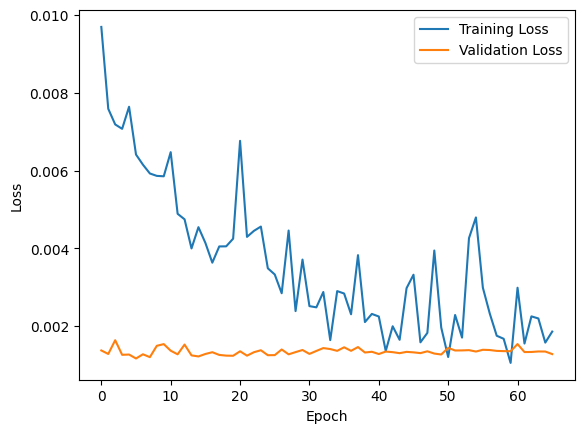

In [88]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [86]:
#model.save('../model_weights/Old_processing.keras')

In [87]:
y_pred = model.predict(X_test)


# Scaling y_pred back to the original scale
y_pred_scaled = scaler.inverse_transform(y_pred)

r2 = r2_score(y_test_un, y_pred_scaled)
print("R2 Score: ", r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
R2 Score:  0.27509634851596965


In [91]:
max = y_train_un.max()
min = y_train_un.min()
loaded_model = tf.keras.models.load_model('../model_weights/Bigger_R2_42_Pool_3_3.keras', custom_objects={'Augment': Augment})
scaled_predictions = loaded_model.predict(X_test)
original_predictions = scaled_predictions * (max - min) + min

r2 = r2_score(y_test_un, original_predictions)
print(r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
0.41040413966204403


In [168]:
loaded_model = tf.keras.models.load_model('../model_weights/CNN_padded_images.keras', custom_objects={'Augment': Augment})
y_pred = loaded_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", r2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
R2 Score:  0.7750346308301239


In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

In [54]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-7:]:
    layer.trainable = True


augment_layer = Augment()
# Input layer
inputs = Input(shape=(256, 256, 3))

# Add the augment layer
x = augment_layer(inputs)

# Pass the augmented images through the ResNet model
x = base_model(x)

# Add global pooling and custom layers
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)

# Create the final model
model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best loss
)




Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment_16 (Augment)            │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,721,473 (90.49 MB)

 Trainable params: 3,549,313 (13.54 MB)

 Non-trainable params: 20,172,160 (76.95 MB)

In [55]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=15,
    callbacks=[early_stopping]
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 618ms/step - loss: 0.1959 - mean_absolute_error: 0.2686 - val_loss: 0.0081 - val_mean_absolute_error: 0.0822
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 49s 603ms/step - loss: 0.0094 - mean_absolute_error: 0.0459 - val_loss: 0.0049 - val_mean_absolute_error: 0.0588
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 584ms/step - loss: 0.0080 - mean_absolute_error: 0.0408 - val_loss: 0.0045 - val_mean_absolute_error: 0.0405
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 582ms/step - loss: 0.0129 - mean_absolute_error: 0.0439 - val_loss: 0.0055 - val_mean_absolute_error: 0.0460
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 48s 588ms/step - loss: 0.0109 - mean_absolute_error: 0.0462 - val_loss: 0.0036 - val_mean_absolute_error: 0.0355
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 48s 588ms/step - loss: 0.0112 - mean_absolute_error: 0.0440 - val_loss: 0.0035 - val_mean_absolute_error: 0.0376
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - loss: 0.0086 - mean_absolute_error: 0.0

In [57]:
metric = tf.metrics.R2Score()
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", r2)

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 890ms/step
R2 Score:  0.10469072408692237


In [60]:
X = np.array([preprocess_image('../data/padded_images/resized_' + file) for file in valid_df['img_file']])
y = valid_df['Bags used '].values
file_names = valid_df['img_file'].values  # Get the file names

# Split data into train and test sets
X_train, X_test, y_train_un, y_test_un, train_files, test_files = train_test_split(X, y, file_names, test_size=0.2, random_state=42)


Test file names: ['p1156.jpg' 'p154.jpg' 'p245.jpg' 'p928.jpg' 'p1121.jpg' 'p1655.jpg'
 'p1038.jpg' 'p963.jpg' 'p1515.jpg' 'p294.jpg' 'p1080.jpg' 'p1248.jpg'
 'p1264.jpg' 'p1232.jpg' 'p1586.jpg' 'p420.jpg' 'p39.jpg' 'p423.jpg'
 'p1291.jpg' 'p460.jpg' 'p1267.jpg' 'p135.jpg' 'p284.jpg' 'p1613.jpg'
 'p1212.jpg' 'p928.jpg' 'p974.jpg' 'p1081.jpg' 'p454.jpg' 'p422.jpg'
 'p1144.jpg' 'p124.jpg' 'p1246.jpg' 'p1571.jpg' 'p69.jpg' 'p1179.jpg'
 'p1602.jpg' 'p972.jpg' 'p426.jpg' 'p1577.jpg' 'p1168.jpg' 'p52.jpg'
 'p1271.jpg' 'p1049.jpg' 'p943.jpg' 'p499.jpg' 'p1563.jpg' 'p996.jpg'
 'p291.jpg' 'p940.jpg' 'p1527.jpg' 'p271.jpg' 'p979.jpg' 'p456.jpg'
 'p1619.jpg' 'p192.jpg' 'p498.jpg' 'p476.jpg' 'p1586.jpg' 'p1140.jpg'
 'p1551.jpg' 'p1560.jpg' 'p1017.jpg' 'p278.jpg' 'p1259.jpg' 'p1667.jpg'
 'p276.jpg' 'p1190.jpg' 'p197.jpg' 'p283.jpg' 'p1049.jpg' 'p1344.jpg'
 'p184.jpg' 'p1123.jpg' 'p1187.jpg' 'p935.jpg' 'p932.jpg' 'p933.jpg'
 'p174.jpg' 'p1588.jpg' 'p296.jpg' 'p949.jpg' 'p1098.jpg' 'p439.jpg'
 'p1568

In [118]:
input_img = load_img("../data/padded_images/resized_p142.jpg")

img_width, img_height = 256, 256
input_img = input_img.resize((img_width, img_height))
img_array = img_to_array(input_img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
loaded_model = tf.keras.models.load_model('../model_weights/CNN_padded_images.keras', custom_objects={'Augment': Augment})
prediction = loaded_model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.03983825]]
